In [3]:
sys.path.append('/scratch/mz2476/DL/project/')

In [4]:
import cv2

import sys

sys.path.append('/workspace/work/')

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
from ssl_project.data_loaders import plot_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ssl_project.data_loaders.data_helper import UnlabeledDataset, LabeledDataset
from ssl_project.data_loaders.helper import collate_fn, draw_box
from ssl_project import constants

from ssl_project.preprocessing import top_down_segmentation


from ssl_project.utils import to_np

In [6]:
from ssl_project.preprocessing import projections

# create labeled data

In [14]:
from ssl_project.constants import LABELED_SCENE_INDEX

for scene_idx in LABELED_SCENE_INDEX:
    projections.create_label_data_road_only(scene_idx)

100%|██████████| 126/126 [00:12<00:00, 10.36it/s]


In [8]:
import imageio

In [12]:
label = imageio.imread("../data/scene_106/sample_1/ROAD_SEGM_CAM_BACK_LEFT.png")
photo = imageio.imread("../data/scene_106/sample_1/CAM_BACK_LEFT.jpeg")

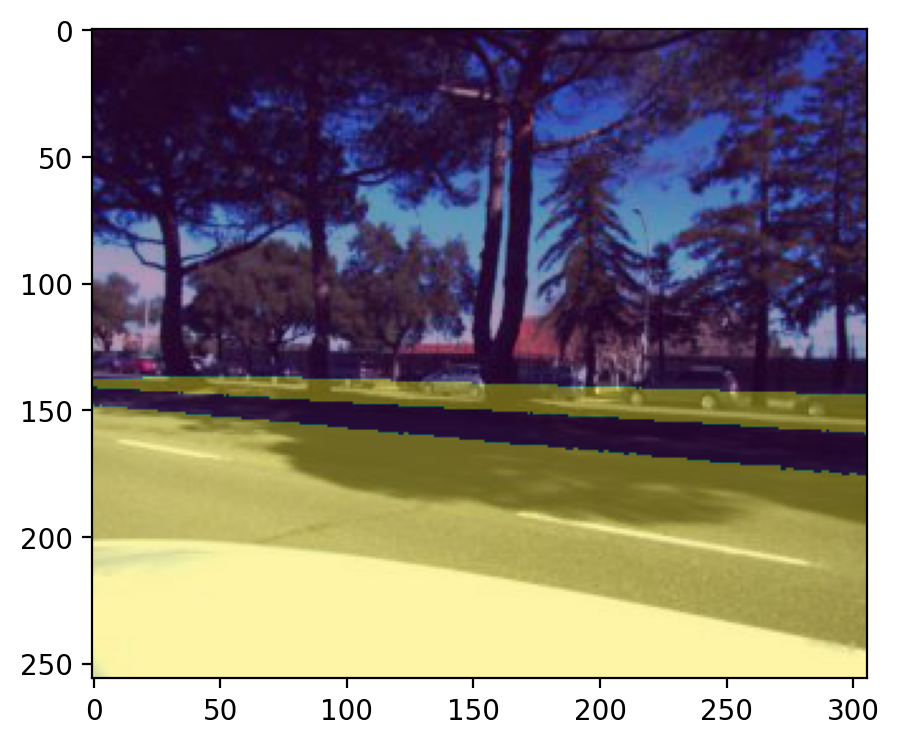

In [13]:
plt.imshow(photo)
plt.imshow(label, alpha=0.4)

In [3]:
# top_down_segmentation.VALUE_TO_CATEGORY

# top_down_segmentation.create_data()

# create segmentaion and distance

In [15]:
projections.create_data_all(n_jobs=4, debug=False)

In [4]:
projections.create_label_data(107)

  1%|          | 1/126 [00:09<20:19,  9.75s/it]


KeyboardInterrupt: 

In [13]:
scene_id = 107
sample_id = 0
name = 'CAM_FRONT'
photo_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/{name}.jpeg", cv2.IMREAD_UNCHANGED)
segm_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/SEGM_{name}.png", cv2.IMREAD_UNCHANGED)
dist_hw = cv2.imread(f"../data/scene_{scene_id}/sample_{sample_id}/DIST_{name}.png", cv2.IMREAD_UNCHANGED)

fig, axis = plt.subplots(1, 1)

axis.imshow(photo_hw)
axis.imshow(segm_hw, alpha=0.5)
# axis.imshow(dist_hw, alpha=1)

# trying to rotate

In [4]:
mask = cv2.imread("../data/scene_106/sample_70/top_down_segm.png", cv2.IMREAD_UNCHANGED)

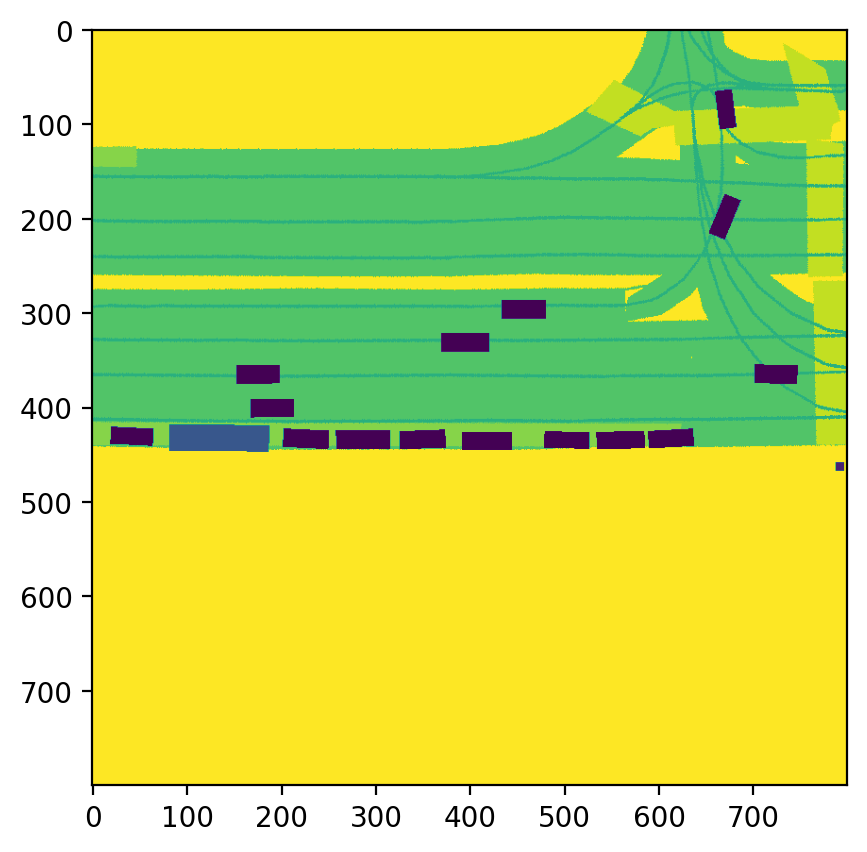

In [5]:
fig, axis = plt.subplots(1, 1)
axis.imshow(mask)

In [6]:
import numpy as np

GROUND_CAT = 13
assert top_down_segmentation.VALUE_TO_CATEGORY[GROUND_CAT] == 'ground'


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result  = cv2.warpAffine(image, rot_mat, image.shape[1::-1], 
                             flags=cv2.INTER_NEAREST, borderValue=GROUND_CAT)
    return result

In [7]:
rot_v2 = rotate_image(mask, -60)

<IPython.core.display.Javascript object>


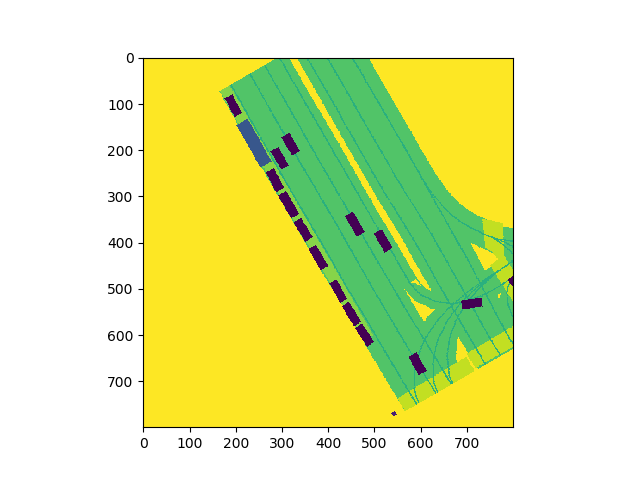

In [132]:
fig, axis = plt.subplots(1, 1)
axis.imshow(rot_v2)

In [48]:
plt.imshow(13 - rot_v2)

In [15]:
rotated

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
cv2.rotate(mask, 0.5)

TypeError: integer argument expected, got float

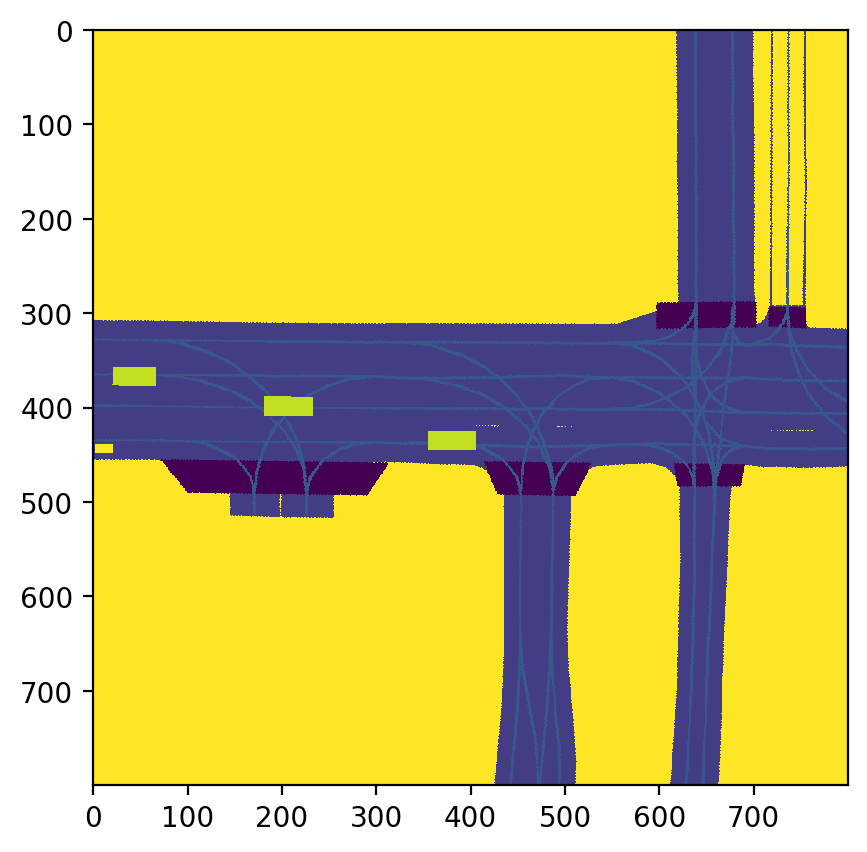

# Projection

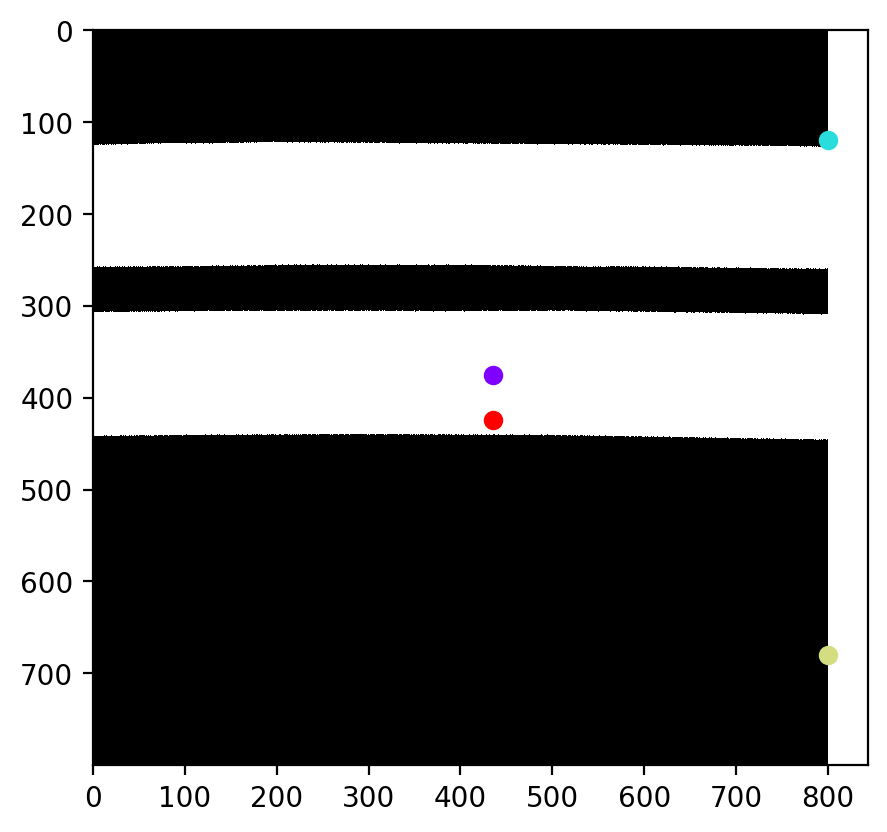

In [28]:
center = 400
front_x, back_x = 435, 800

alpha = np.radians(70)

offset_front_y, offset_back_y = (
    np.tan(alpha / 2) * (front_x - center), 
    np.tan(alpha / 2) * (back_x - center)
)

points_src = np.array([
    [front_x, 400 - offset_front_y],
    [back_x, 400 - offset_back_y],
    [back_x, 400 + offset_back_y],
    [front_x, 400 + offset_front_y],
])

# plot_utils.plot_bb(road_image, target, [7])
plt.imshow(im_src)

colors = cm.rainbow(np.linspace(0, 1, 4))
for (x, y), c in zip(points_src, colors):
    plt.scatter(x, y, color=c)
# plt.scatter(points_src[:, 0], points_src[:, 1])

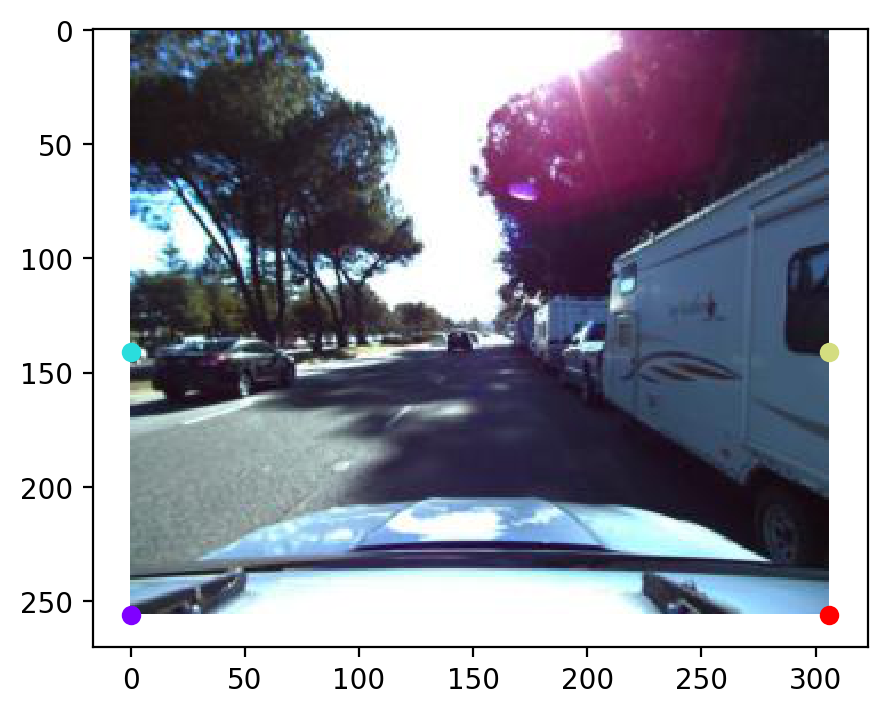

In [33]:
im_tgt = to_np(sample[1]).transpose(1, 2, 0)

offset_z = im_tgt.shape[0] * 0.55 

points_tgt = np.array([
    [0, im_tgt.shape[0]],
    [0, offset_z],
    [im_tgt.shape[1], offset_z],
    [im_tgt.shape[1], im_tgt.shape[0]],
])

plt.imshow(im_tgt)

colors = cm.rainbow(np.linspace(0, 1, 4))
for (x, y), c in zip(points_tgt, colors):
    plt.scatter(x, y, color=c)
# plt.scatter(points_tgt[:, 0], points_tgt[:, 1])

In [34]:
from ssl_project.utils import to_np

In [35]:
points_src, points_tgt = points_src.astype("float32"), points_tgt.astype("float32")
M = cv2.getPerspectiveTransform(points_src, points_tgt)

In [36]:
# warped = cv2.warpPerspective(im_tgt,
#                              M, (im_tgt.shape[1], im_tgt.shape[0]))

In [37]:
warped = cv2.warpPerspective(im_src, M, (im_tgt.shape[1], im_tgt.shape[0] // 2))

In [38]:
warped.shape

(128, 306, 3)

In [39]:
warped.shape

(128, 306, 3)

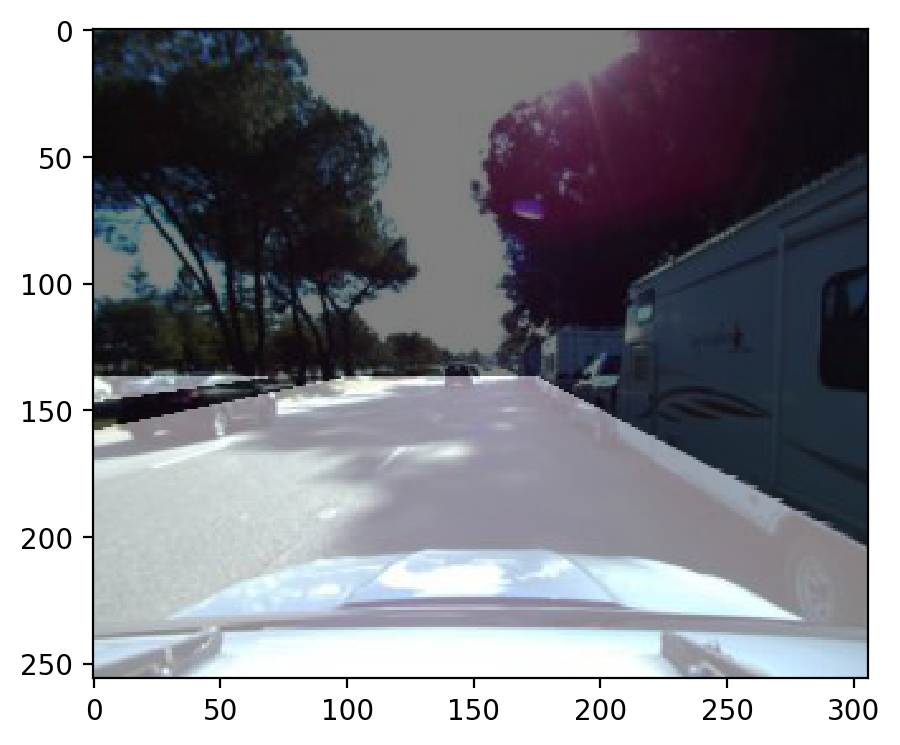

In [40]:
plt.imshow(im_tgt)

plt.imshow(np.concatenate((np.zeros_like(warped), warped[::-1, ::-1])), alpha=0.5)